In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm

In [3]:
import random
random.seed(42)

In [4]:
from PIL import Image

In [5]:
from glob import glob

In [6]:
plt.set_cmap("cividis")
# %matplotlib inline
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0

<Figure size 432x288 with 0 Axes>

In [7]:
NUM_WORKERS = 6
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 6


# <font size="8">Contrastive Learning</font>

<font size="5">A fundamental idea behind most machine learning algorithms is that similar examples should be grouped together and far from other clusters of related examples.</font>

<img src="./figs/D6mg.gif" width="750" />

# <font size="8">CPC (Contrastive Predictive Coding)</font>

<font size="5">CPC introduces the idea of learning representations by predicting the “future” in latent space. In practice this means two things: <\font>

<font size="5"> 1) Treat an image as a timeline with the past at the top left and the future at the bottom right.</font>

<img src="./figs/pig.gif" width="650" />

<font size="5"> 2) The predictions don’t happen at the pixel level, but instead, they use the outputs of the encoder (ie: the latent space)</font>

<img src="./figs/pig 2.gif" width="750" />

<font size="5"> 3) Finally, the representation extraction happens by formulating a prediction task using the output of the encoder (H) as targets to the context vectors generated by a projection head. </font>

<img src="./figs/pig 3.gif" width="750" />

<img src="./figs/SimCLR.gif" width="750" />

In [8]:
class GW_data(data.Dataset):
    
    def __init__(self,is_unlabel:bool=False, transform=None):
        noise_data = glob('/media/felipe/home 2/GW_playgorund/new project/data Osvaldo/classifier_long/noise/*.png')
        scatter_data = glob('/media/felipe/home 2/GW_playgorund/new project/data Osvaldo/classifier_long/scattered_light/*.png')
        blip_data = glob('/media/felipe/home 2/GW_playgorund/new project/data Osvaldo/classifier_long/blip/*.png')
        signal_data = glob('/media/felipe/home 2/GW_playgorund/new project/data Osvaldo/classifier_long/signal/*.png')
        self.all_data = noise_data + scatter_data + blip_data + signal_data
        if is_unlabel:
            self.all_data = random.sample(self.all_data, int(0.35*len(self.all_data)))
        self.targets = torch.eye(len(self.all_data), dtype=torch.int16)
        self.transform = transform
                
    def __len__(self):
        return len(self.all_data)
    
    def __getitem__(self, idx):
        x = Image.open(self.all_data[idx])
        y = self.targets[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [10]:
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ContrastiveLearning/")
pretrained_files = [
    "SimCLR.ckpt",
    "ResNet.ckpt",
    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
    "tensorboards/classification/ResNet/events.out.tfevents.ResNet",
]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [11]:
class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [12]:
contrast_transforms = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [13]:
unlabeled_data = GW_data(is_unlabel=True,transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = GW_data(is_unlabel=False,transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Global seed set to 42


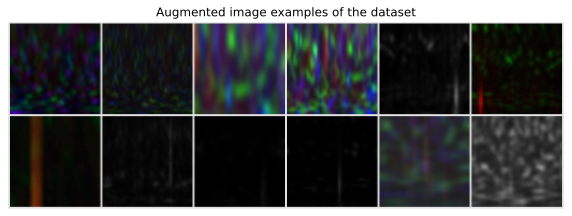

In [14]:
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [15]:
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            pretrained=False, num_classes=4 * hidden_dim
        )  # num_classes is the output size of the last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

In [16]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
        gpus=1 if str(device) == "cuda:0" else 0,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
            LearningRateMonitor("epoch"),
        ],
        progress_bar_refresh_rate=1,
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        val_loader = data.DataLoader(
            train_data_contrast,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        pl.seed_everything(42)  # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [17]:
simclr_model = train_simclr(
    batch_size=256, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Missing logger folder: saved_models/ContrastiveLearning/SimCLR/lightning_logs

  | Name    | Type   | Params
-----------------------------------
0 | convnet | ResNet | 11.5 M
-----------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]